# KerasNLP Contradictory MyDearWatson
- To assign label to pairs of premises and hypotheses
- The labels can be entailment, neutral or contradiction
- The dataset contains text in 15 languages

In [3]:
!pip install keras-nlp --upgrade


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import warnings

# turn of warnings
warnings.filterwarnings('ignore')

# version checking
print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

Tensorflow version: 2.12.0
KerasNLP version: 0.6.1


# Using TPU
- Tensor processing unit

In [8]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print('TPU not activated')
    strategy = tf.distribute.MirroredStrategy()
print('replicas:', strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# Load the Dataset

In [9]:
DATA_DIR = '/kaggle/input/contradictory-my-dear-watson/'

RESULT_DICT = {
    0 : 'entailment',
    1 : 'neutral',
    2 : 'contradiction'
}

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [10]:
# the train set
df_train = pd.read_csv(DATA_DIR + 'train.csv')
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [11]:
# the test set
df_test = pd.read_csv(DATA_DIR + 'test.csv')
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [13]:
# look at the sentences pair
def display_pair_of_sentence(x):
    print('Premise: ' + x['premise'])
    print('Hypothesis: ' + x['hypothesis'])
    print('Language: ' + x['language'])
    print('Label: ' + str(x['label']))
    print()

df_train.head(n = 10).apply(lambda x: display_pair_of_sentence(x), axis = 1)
df_train.shape

Premise: and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise: These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise: Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise: you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise: ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต

(12120, 6)

# Data Exploration

Text(0.5, 1.0, 'Distribution of labels in the training set')

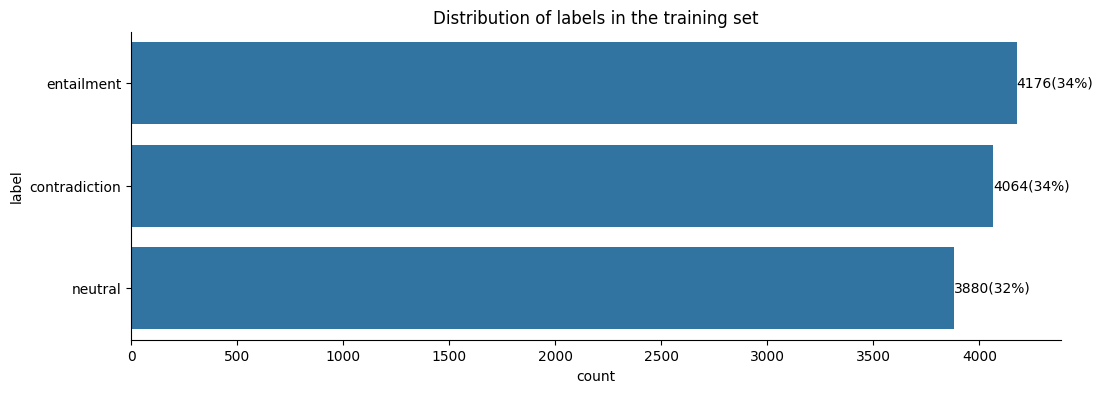

In [14]:
# label distribution
f, ax = plt.subplots(figsize = (12, 4))

# plot total crashes
sns.set_color_codes('pastel')
sns.despine()
ax = sns.countplot(data = df_train, y = 'label', order = df_train['label'].value_counts().index)
abs_values = df_train['label'].value_counts(ascending = False)
rel_values = df_train['label'].value_counts(ascending = False, normalize = True).values * 100
lbls = [f'{p[0]}({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container = ax.containers[0], labels = lbls)
ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])
ax.set_title('Distribution of labels in the training set')

Text(0.5, 1.0, 'Distribution of labels in the training set')

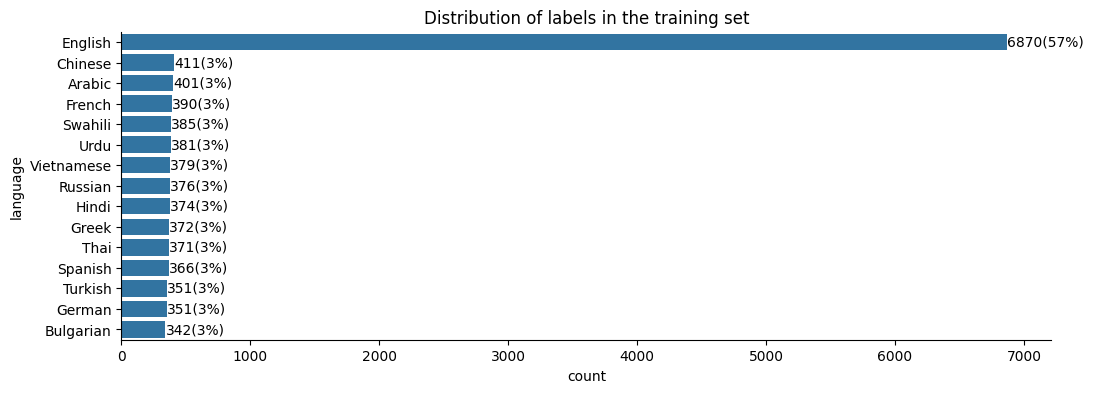

In [16]:
# language distribution
f, ax = plt.subplots(figsize = (12, 4))

# plot total crashes
sns.set_color_codes('pastel')
sns.despine()
ax = sns.countplot(data = df_train, y = 'language', order = df_train['language'].value_counts().index)
abs_values = df_train['language'].value_counts(ascending = False)
rel_values = df_train['language'].value_counts(ascending = False, normalize = True).values * 100
lbls = [f'{p[0]}({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container = ax.containers[0], labels = lbls)
ax.set_title('Distribution of labels in the training set')

In [17]:
# sentences length distribution
df_train['premise_length'] = df_train['premise'].apply(lambda x : len(x))
df_train['hypothesis_length'] = df_train['hypothesis'].apply(lambda x : len(x))
df_train[['premise_length', 'hypothesis_length']].describe()

,premise_length,hypothesis_length
count,12120.000000,12120.000000
mean,107.373185,53.892327
std,71.089954,25.302358
min,4.000000,4.000000
25%,55.000000,36.000000
50%,96.000000,51.000000
75%,146.000000,67.000000
max,967.000000,276.000000


# Data Preprocessing

In [20]:
# setting parameters
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_train.shape[0]*(1 - VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [21]:
def split_labels(x, y):
    return(x[0], x[1]), y

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_train[['premise', 'hypothesis']].values,
            keras.utils.to_categorical(df_train['label'], num_classes = 3)
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder = True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder = True).cache().prefetch(tf.data.AUTOTUNE)

# Using the BERT Model

In [23]:
with strategy.scope():
    classifier = keras_nlp.models.BertClassifier.from_preset('bert_base_multi', num_classes = 3)
    classifier.compile(optimizer = keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync), loss = keras.losses.CategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
    classifier.summary()

711647480/711647480 [==============================] - 4s 0us/step


Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                             119,547 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     177,853,440 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 3)                              │           2,307 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 177,855,747 (678.47 MB)

 Trainable params: 177,855,747 (678.47 MB)

 Non-trainable params: 0 (0.00 B)

# Train The Model

In [25]:
EPOCHS = 4
history = classifier.fit(
    train_preprocessed,
    epochs = EPOCHS,
    validation_data = val_preprocessed
)

Epoch 1/4


2023-10-15 09:08:59.795377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-15 09:09:00.701126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


66/66 [==============================] - ETA: 0s - loss: 0.9859 - accuracy: 0.5050

2023-10-15 09:10:24.818549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-15 09:10:25.082798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


66/66 [==============================] - 127s 667ms/step - loss: 0.9859 - accuracy: 0.5050 - val_loss: 0.9238 - val_accuracy: 0.5617
Epoch 2/4
66/66 [==============================] - 33s 490ms/step - loss: 0.7720 - accuracy: 0.6629 - val_loss: 1.0081 - val_accuracy: 0.5887
Epoch 3/4
66/66 [==============================] - 32s 493ms/step - loss: 0.5763 - accuracy: 0.7643 - val_loss: 1.0616 - val_accuracy: 0.6097
Epoch 4/4
66/66 [==============================] - 33s 496ms/step - loss: 0.4640 - accuracy: 0.8195 - val_loss: 1.0668 - val_accuracy: 0.5951


# Generate Submission File

In [26]:
predictions = classifier.predict(
    (df_test['premise'], df_test['hypothesis']),
    batch_size = BATCH_SIZE
)

2023-10-15 09:12:29.350041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-15 09:12:29.572008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


41/41 [==============================] - 27s 353ms/step


In [27]:
submission = df_test.id.copy().to_frame()
submission['prediction'] = np.argmax(predictions, axis = 1)
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


In [28]:
# save the output
submission.to_csv('submission.csv', index = False)